## Homework 3

In [1]:
import numpy as np
from numpy.random import multivariate_normal, chisquare

from openpyxl import load_workbook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.special import gamma
# from scipy.stats import kendalltau, norm, t, chi2
import scipy.stats as st

### Problem 1

For two variables to be of the same type, the equation $ X_1 = aX_2 + b $ has to be true. However, this is not the case for lognormal distributions with different $\sigma$ parameters. Scaling $X_1$ by a constant parameter $a$ shifts the mean but leaves variance unchanged. if $log(X_1) \sim N(0, \sigma) $, then    $ log(aX_1) \sim N(log(a), \sigma) $

For $\rho_{min}=-1$ and $\rho_{max}=1$ two variables must be of the same type. As stated above, $X_1$ and $X_2$ are not of the same type. Therefore the attainable min/max correlations are (-1, 1).

The copula of $(Z,Z)$ is comonotonic. Since  $(e^Z,e^{\sigma Z})$ are monotonic increasing transformations, the copula must be the same as of $(Z,Z)$. The same logic works for $(e^Z,e^{-\sigma Z})$, but starting with countermonotonic copula of $(Z,-Z)$. The transformations are still monotonic increasing, so the copula stays the same for $(e^Z,e^{-\sigma Z})$, which is countermonotonic.

To calculate $\rho_{\min}$ and $\rho_{\max}$ let's first calculate the variance of $e^Z$.

$$\mathbb{E}[e^Z] = e^{1/2}$$

$$\mathbb{E}[e^2Z] = e^{2}$$

$$\mathbb{V}[e^Z] = \mathbb{E}[e^2Z] - \mathbb{E}[eZ]^2 = e^e-e$$

Now, calculate $\rho_{\max}$

$$
\rho_{\max} = \frac{Cov(e^{Z},e^{\sigma Z})}{\sqrt{\mathbb{V}[e^Z]\mathbb{V}[e^{\sigma Z}]}}
$$
$$
\rho_{\max} = \frac{\mathbb{E}[e^{(\sigma+1)Z}]-\mathbb{E}[e^{\sigma Z}]\mathbb{E}[e^{Z}]}{\sqrt{(e-1)e(e^{\sigma^2}-1)e^{\sigma^2}}}
$$
$$
\rho_{\max} = \frac{e^{(\sigma^2+1)/2}(e^{\sigma}-1)}{\sqrt{(e-1)(e^{\sigma^2}-1)}e^{(\sigma^2+1)/2}}
$$
$$
\rho_{\max} = \frac{e^{\sigma}-1}{\sqrt{(e-1)(e^{\sigma^2}-1)}}
$$
And $\rho_{\min}$
$$
\rho_{\min} = \frac{Cov(e^{Z},e^{-\sigma Z})}{\sqrt{\mathbb{V}[e^Z]\mathbb{V}[e^{-\sigma Z}]}}
$$
$$
\rho_{\min} = \frac{-\,e^{\frac{1+\sigma^2}{2}}(1-e^{-\sigma})}{e^{\frac{1+\sigma^2}{2}}\sqrt{(e-1)(e^{\sigma^2}-1)}}
$$
$$
\rho_{\min} = \frac{e^{-\sigma}-1}{\sqrt{(e-1)(e^{\sigma^2}-1)}}
$$

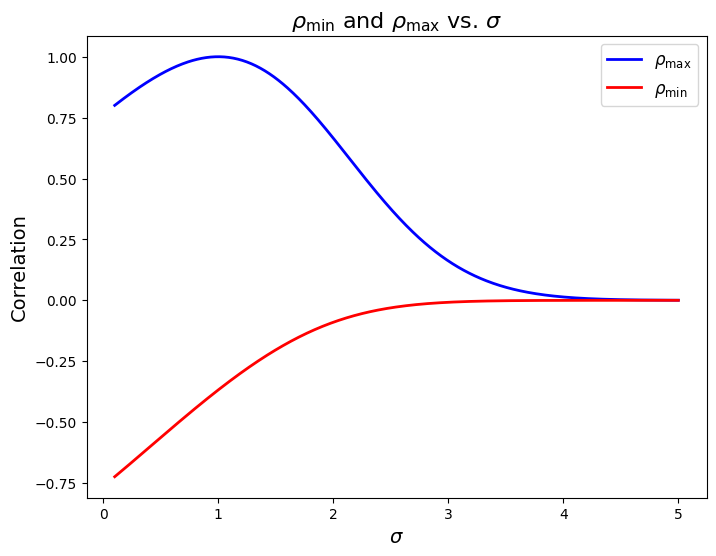

In [2]:
def rho_max(sigma):
    """
    Calculate the maximum correlation rho_max for a given sigma.
    """
    return (np.exp(sigma) - 1) / np.sqrt((np.e - 1) * (np.exp(sigma**2) - 1))

def rho_min(sigma):
    """
    Calculate the minimum correlation rho_min for a given sigma.
    """
    return (np.exp(-sigma) - 1) / np.sqrt((np.e - 1) * (np.exp(sigma**2) - 1))

# Create an array of sigma values in the interval [0.1, 5]
sigma_values = np.linspace(0.1, 5, 500)

# Calculate rho_max and rho_min for these sigma values
rho_max_values = rho_max(sigma_values)
rho_min_values = rho_min(sigma_values)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(sigma_values, rho_max_values, label=r'$\rho_{\max}$', color='blue', lw=2)
plt.plot(sigma_values, rho_min_values, label=r'$\rho_{\min}$', color='red', lw=2)
plt.xlabel(r'$\sigma$', fontsize=14)
plt.ylabel('Correlation', fontsize=14)
plt.title(r'$\rho_{\min}$ and $\rho_{\max}$ vs. $\sigma$', fontsize=16)
plt.legend(fontsize=12)
plt.show()


#### Observations 
- both $\rho_{min}$ and $\rho_{max}$ converge to zero as $\sigma-> \inf$
- $\rho_{max}$ is largest when $\sigma->1$
- $\rho_{min}$ is smallest when $\sigma->0$

### Problem 2

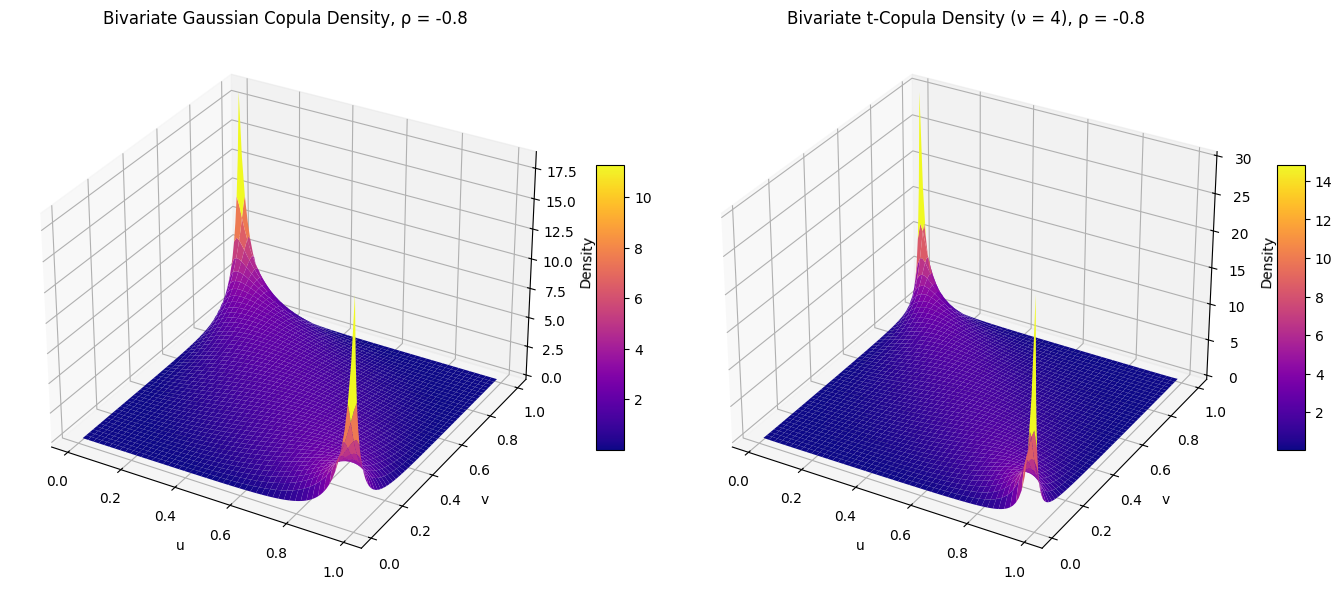

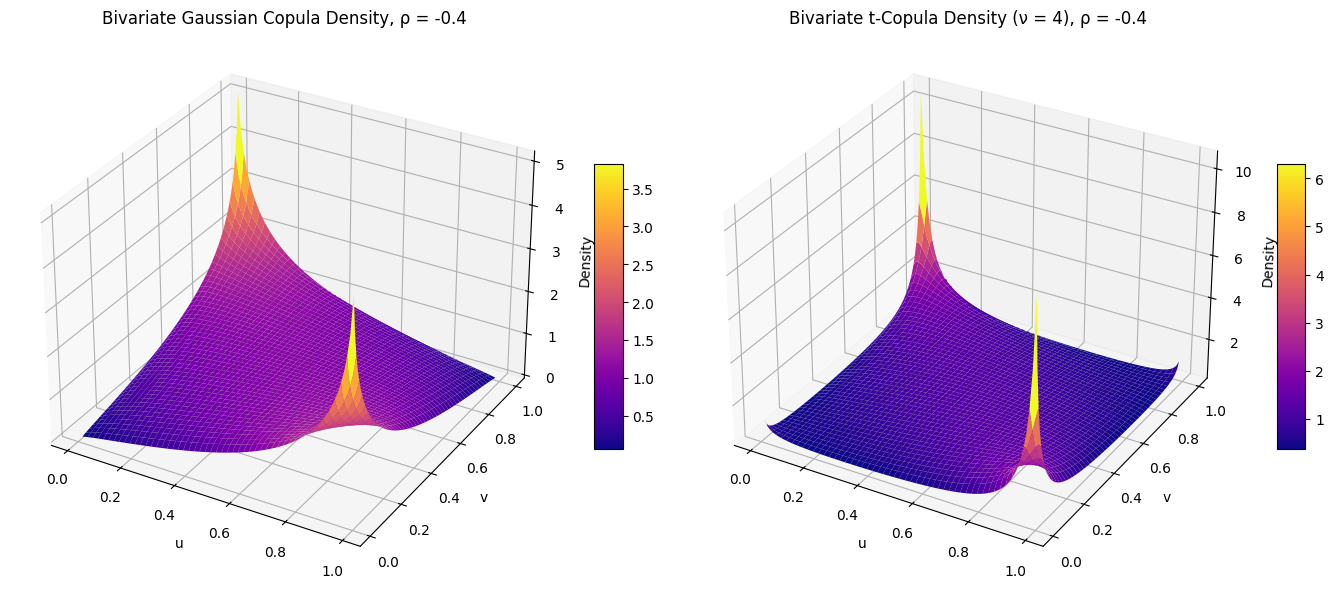

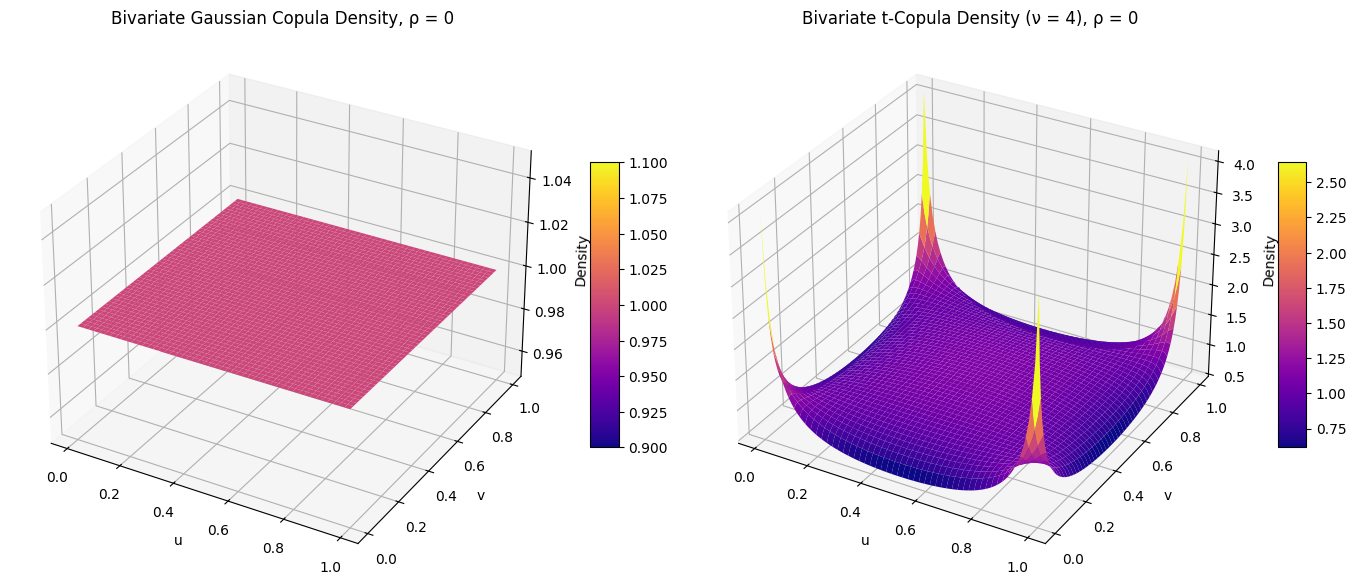

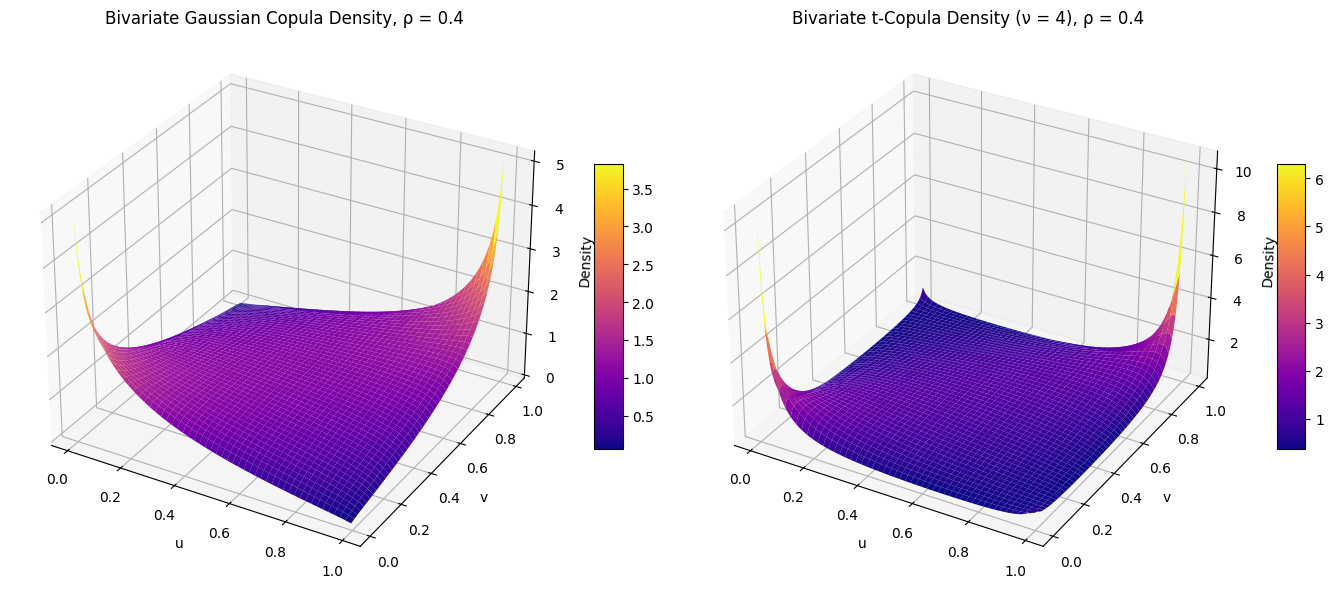

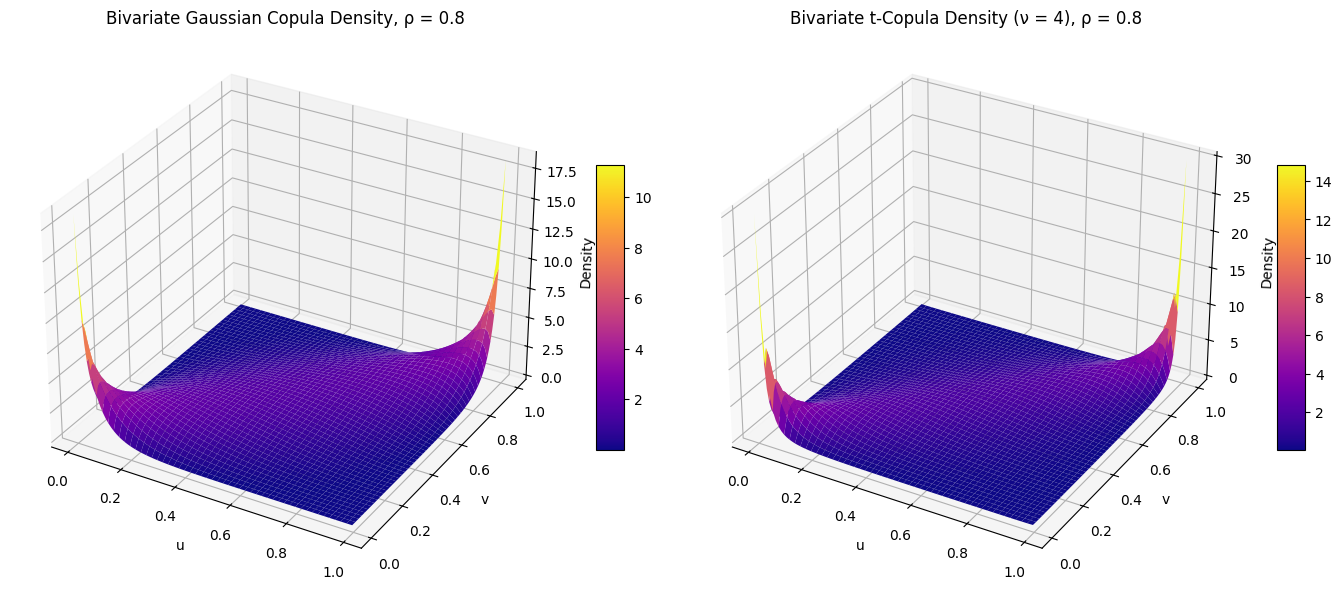

In [3]:
def plot_copula_densities(rho, nu=4):
    """
    Plot the 3D surfaces for the bivariate Gaussian copula density and the
    bivariate t-copula density (with nu degrees of freedom) for a given correlation rho.
    
        rho: the correlation parameter for the copulas.
        nu: degrees of freedom for the t-copula (default 4).
    """
    # Create a grid of u and v values in (0,1)
    u = np.arange(0.01, 0.999, 0.01)
    v = np.arange(0.01, 0.999, 0.01)
    U, V = np.meshgrid(u, v)
    
    # --- Gaussian Copula Density ---
    # Compute the inverse standard normal CDF (ppf) for u and v
    z1 = st.norm.ppf(U)
    z2 = st.norm.ppf(V)
    # Gaussian copula density is given by:
    c_gauss = 1/np.sqrt(1 - rho**2) * \
              np.exp((2 * rho * z1 * z2 - rho**2 * (z1**2 + z2**2)) / (2 * (1 - rho**2)))
    
    # --- t-Copula Density ---
    # Compute the inverse t CDF (ppf) for u and v with nu degrees of freedom
    x = st.t.ppf(U, df=nu)
    y = st.t.ppf(V, df=nu)
    
    # Bivariate t density with correlation rho and df=nu:
    factor = 1 + (x**2 - 2*rho*x*y + y**2) / (nu * (1 - rho**2))
    t2_xy = (gamma((nu + 2) / 2) / (gamma(nu / 2) * np.pi * nu * np.sqrt(1 - rho**2))) * \
            factor**(-(nu + 2) / 2)
    
    # Marginal t density for each coordinate:
    t_x = st.t.pdf(x, df=nu)
    t_y = st.t.pdf(y, df=nu)
    
    # t-copula density is the ratio of the joint t density to the product of the marginals:
    c_t = t2_xy / (t_x * t_y)
    
    # --- Plot ---
    fig = plt.figure(figsize=(14, 6))
    
    # gauss
    ax1 = fig.add_subplot(121, projection='3d')
    surf1 = ax1.plot_surface(U, V, c_gauss, cmap='plasma', edgecolor='none')
    ax1.set_title(f'Bivariate Gaussian Copula Density, ρ = {rho}', fontsize=12)
    ax1.set_xlabel('u')
    ax1.set_ylabel('v')
    ax1.set_zlabel('Density')
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)
    
    # t-copula
    ax2 = fig.add_subplot(122, projection='3d')
    surf2 = ax2.plot_surface(U, V, c_t, cmap='plasma', edgecolor='none')
    ax2.set_title(f'Bivariate t-Copula Density (ν = {nu}), ρ = {rho}', fontsize=12)
    ax2.set_xlabel('u')
    ax2.set_ylabel('v')
    ax2.set_zlabel('Density')
    fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)
    
    plt.tight_layout()
    plt.show()

# Run the function for several values of rho
rho_values = [-0.8, -0.4, 0, 0.4, 0.8]
for rho in rho_values:
    # print(f"Plotting for rho = {rho}")
    plot_copula_densities(rho, nu=4)


#### Observations:
- Student's distribution places higher probability to the corners (-1, 1) for negative $\rho$ and (1, 1) for positive $\rho$.
- The distribution is along the positive-sloped line when $\rho$ is positive and along the negatively sloped line when $\rho$ is negative.
- The behavior when $\rho=0$ is peculiar. The Gaussian copula is completely flat - equal mass to all points. The Student's t distribution still places some weight on the corners.

### Problem 3

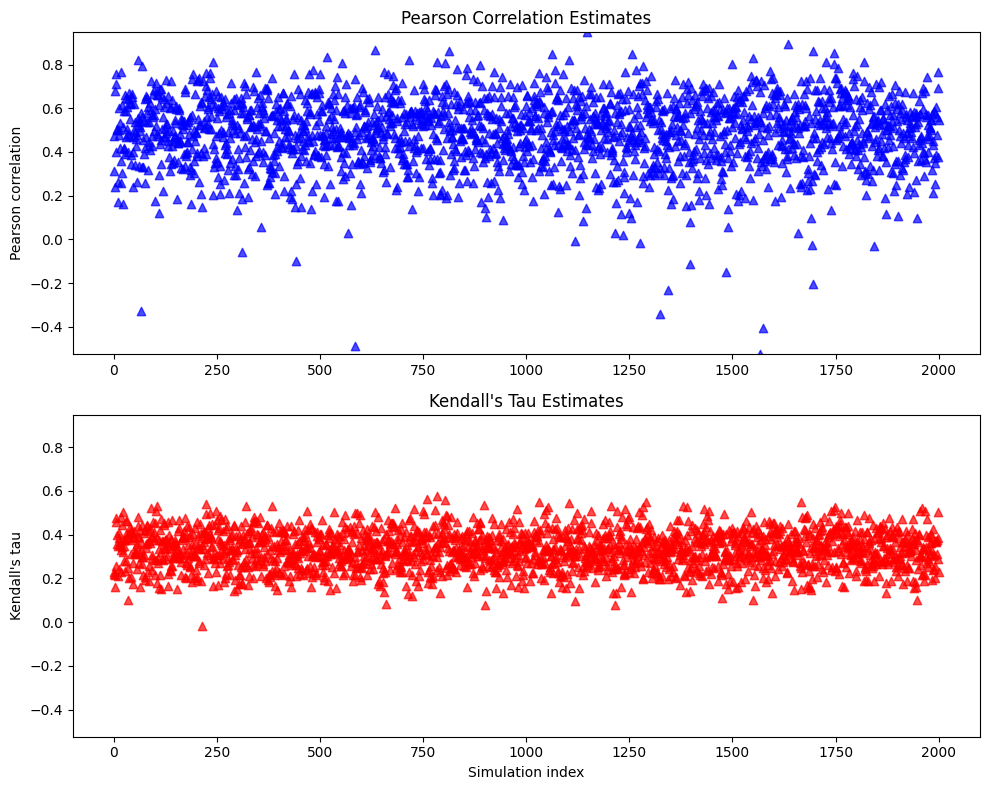

In [4]:
def simulate_bivariate_t(n, nu, mu, rho):
    """
    Simulate n samples from a bivariate t-distribution with
    nu degrees of freedom, mean vector mu (length 2), and correlation rho.
    
    Parameters:
        n: Number of samples.
        nu: Degrees of freedom.
        mu: Mean vector (length 2).
        rho: Correlation.
    
    Returns:
        T: Array of shape (n, 2) with simulated bivariate t samples.
    """
    Sigma = np.array([[1, rho], [rho, 1]])
    
    # Generate n samples from bivariate normal with mean [0, 0] and covariance Sigma
    Z = multivariate_normal(mean=[0, 0], cov=Sigma, size=n)
    
    # Generate n samples from a chi-square distribution with nu degrees of freedom
    V = chisquare(nu, size=n)
    
    # Scale factor for each sample
    scale = np.sqrt(V / nu).reshape(-1, 1)
    
    # Create t distributed samples
    T = np.array(mu) + Z / scale
    return T

def estimate_correlations(n, nu, mu, rho):
    """
    Simulate one dataset from a bivariate t distribution and compute:
      (i) the Pearson correlation coefficient,
      (ii) Kendall's tau.
    
    Parameters:
        n: Number of samples.
        nu: Degrees of freedom.
        mu: Mean vector.
        rho: Correlation parameter.
    
    Returns:
        (pearson_est, kendall_est): tuple of estimated correlations.
    """
    samples = simulate_bivariate_t(n, nu, mu, rho)
    
    # Pearson correlation estimate
    pearson_est = np.corrcoef(samples[:, 0], samples[:, 1])[0, 1]
    
    # Kendall's tau estimate
    kendall_est = st.kendalltau(samples[:, 0], samples[:, 1]).correlation
    
    return pearson_est, kendall_est

def run_simulations(n_trials, n, nu, mu, rho):
    """
    Run n_trials simulations and record the Pearson and Kendall tau estimates.
    
    Parameters:
        n_trials: Number of simulation runs.
        n: Sample size in each run.
        nu: Degrees of freedom.
        mu: Mean vector.
        rho: True correlation parameter.
    
    Returns:
        pearson_estimates: Array of Pearson estimates.
        kendall_estimates: Array of Kendall tau estimates.
    """
    pearson_estimates = np.zeros(n_trials)
    kendall_estimates = np.zeros(n_trials)
    
    for i in range(n_trials):
        p_est, k_est = estimate_correlations(n, nu, mu, rho)
        pearson_estimates[i] = p_est
        kendall_estimates[i] = k_est
        
    return pearson_estimates, kendall_estimates

def plot_scatter_estimates(pearson_estimates, kendall_estimates):
    """
    Create two scatter plots (one above the other) for the Pearson and Kendall tau estimates.
    Each data point is marked with a triangle.
    The y-axis range is kept the same for both plots.
    
    Parameters:
        pearson_estimates (np.ndarray): Array of Pearson estimates.
        kendall_estimates (np.ndarray): Array of Kendall tau estimates.
    """
    n_trials = len(pearson_estimates)
    x = np.arange(1, n_trials + 1)
    
    # Determine common y-axis limits
    y_min = min(np.min(pearson_estimates), np.min(kendall_estimates))
    y_max = max(np.max(pearson_estimates), np.max(kendall_estimates))
    
    plt.figure(figsize=(10, 8))
    
    # Scatter plot for Pearson estimates
    ax1 = plt.subplot(2, 1, 1)
    ax1.scatter(x, pearson_estimates, marker='^', color='blue', alpha=0.7)
    ax1.set_title("Pearson Correlation Estimates")
    ax1.set_ylabel("Pearson correlation")
    ax1.set_ylim([y_min, y_max])
    
    # Scatter plot for Kendall tau estimates
    ax2 = plt.subplot(2, 1, 2)
    ax2.scatter(x, kendall_estimates, marker='^', color='red', alpha=0.7)
    ax2.set_title("Kendall's Tau Estimates")
    ax2.set_xlabel("Simulation index")
    ax2.set_ylabel("Kendall's tau")
    ax2.set_ylim([y_min, y_max])
    
    plt.tight_layout()
    plt.show()

# Parameters for simulation
n_trials = 2000
n = 60
nu = 4
rho_true = 0.5
mu = [0, 0]

# Run the simulations
pearson_estimates, kendall_estimates = run_simulations(n_trials, n, nu, mu, rho_true)

# Plot the scatter plots of the correlation estimates
plot_scatter_estimates(pearson_estimates, kendall_estimates)


#### Observations
It's clear from the scatter plots that the Pearson correlation estimates are more variable than the Kendall tau estimates. This is expected because the Pearson correlation is sensitive to outliers and non-linear relationships, while Kendall's tau is a rank-based measure that is more robust to such issues.


### Problem 4

Pricing basket options with i = 1 (call-on-max):

Gaussian Copula:
Method: gaussian, i=1, K=1.60 -> Price = 0.0649
Method: gaussian, i=1, K=1.65 -> Price = 0.0550
Method: gaussian, i=1, K=1.70 -> Price = 0.0449
Method: gaussian, i=1, K=1.75 -> Price = 0.0369
Method: gaussian, i=1, K=1.80 -> Price = 0.0305
Method: gaussian, i=1, K=1.85 -> Price = 0.0248
Method: gaussian, i=1, K=1.90 -> Price = 0.0205
Method: gaussian, i=1, K=1.95 -> Price = 0.0167
Method: gaussian, i=1, K=2.00 -> Price = 0.0135

t-Copula (nu=4):
Method: t       , i=1, K=1.60 -> Price = 0.0475
Method: t       , i=1, K=1.65 -> Price = 0.0385
Method: t       , i=1, K=1.70 -> Price = 0.0317
Method: t       , i=1, K=1.75 -> Price = 0.0262


Method: t       , i=1, K=1.80 -> Price = 0.0204
Method: t       , i=1, K=1.85 -> Price = 0.0169
Method: t       , i=1, K=1.90 -> Price = 0.0132
Method: t       , i=1, K=1.95 -> Price = 0.0106
Method: t       , i=1, K=2.00 -> Price = 0.0087


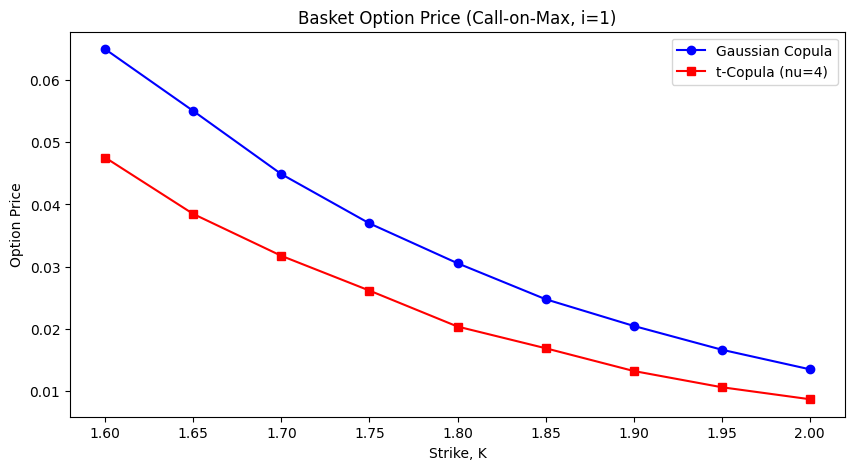


Pricing basket options with i = 2 (call-on-second max):

Gaussian Copula:
Method: gaussian, i=2, K=1.60 -> Price = 0.0231
Method: gaussian, i=2, K=1.65 -> Price = 0.0174
Method: gaussian, i=2, K=1.70 -> Price = 0.0137
Method: gaussian, i=2, K=1.75 -> Price = 0.0108
Method: gaussian, i=2, K=1.80 -> Price = 0.0082
Method: gaussian, i=2, K=1.85 -> Price = 0.0062
Method: gaussian, i=2, K=1.90 -> Price = 0.0049
Method: gaussian, i=2, K=1.95 -> Price = 0.0038
Method: gaussian, i=2, K=2.00 -> Price = 0.0029

t-Copula (nu=4):
Method: t       , i=2, K=1.60 -> Price = 0.0241
Method: t       , i=2, K=1.65 -> Price = 0.0195
Method: t       , i=2, K=1.70 -> Price = 0.0151
Method: t       , i=2, K=1.75 -> Price = 0.0120
Method: t       , i=2, K=1.80 -> Price = 0.0098
Method: t       , i=2, K=1.85 -> Price = 0.0077
Method: t       , i=2, K=1.90 -> Price = 0.0059
Method: t       , i=2, K=1.95 -> Price = 0.0047
Method: t       , i=2, K=2.00 -> Price = 0.0040


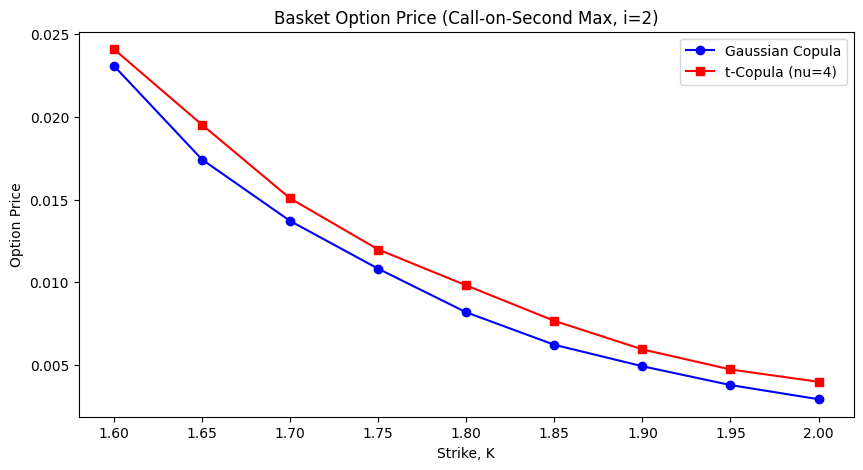

In [5]:
# PARAMETERS
T = 1.0           # Time horizon (years)
r = 0.02          # Risk-free rate
N = 10            # Number of securities in basket
sigma = 0.3       # Volatility (same for all securities)
rho_dep = 0.5     # Equicorrelation parameter in the copula
drift = (r - 0.5*sigma**2)*T  # Drift in the risk-neutral measure

# Create the equicorrelation matrix
R = (1 - rho_dep)*np.eye(N) + rho_dep * np.ones((N, N))
# Cholesky factor:
L = np.linalg.cholesky(R)

def simulate_gaussian_copula(n_paths):
    """
    Simulate terminal prices for N securities under the Gaussian copula.
    We use antithetic variates to reduce variance.
    
    Returns:
       S: array of shape (n_paths*2, N) of terminal prices.
    """
    # Generate independent standard normals for n_half x N, then correlate them via L.
    Z = np.random.randn(n_paths, N)
    X = Z @ L.T
    # Antithetic draws:
    X_full = np.vstack([X, -X])
    
    # Under the risk-neutral dynamics:
    # log(S_j) = drift + sigma * (correlated normal)
    logS = drift + sigma * X_full
    S = np.exp(logS)
    return S

def simulate_t_copula(n_paths, nu):
    """
    Simulate terminal prices for N securities using a t-copula with nu degrees of freedom.
    
    Returns:
       S: array of shape (n_paths, N) of terminal prices.
    """
    # Step 1: Generate Z ~ N(0, R) using the same Cholesky factor L (global variable)
    Z = np.random.randn(n_paths, N) @ L.T
    # Step 2: Generate V ~ chi-square(nu)
    V = np.random.chisquare(nu, size=n_paths)
    V = V.reshape(-1, 1)  # Reshape for proper broadcasting
    # Step 3: Form t variates: each marginal ~ t_nu
    X = Z / np.sqrt(V / nu)
    
    # Step 4: Convert each t variate to U via the t CDF (with nu degrees of freedom)
    U = st.t.cdf(X, df=nu)
    # Step 5: Transform U to standard normal via the inverse CDF
    Y = st.norm.ppf(U)
    # Step 6: Compute logS = drift + sigma * Y, so S is lognormal with the desired parameters.
    logS = drift + sigma * Y
    S = np.exp(logS)
    return S


def price_basket_option(K, i, method, n_paths, nu):
    """
    Price a basket option using the gaussian or t-copula simulation.
    
    Parameters:
       K: strike
       i: rank index (i=1 for call-on-max, i=2 for second max, etc.)
       n_paths: number of simulated paths
       nu: degrees of freedom for the t-copula
    
    Returns:
       Price (discounted expected payoff).
    """
    if method == 'gaussian':
        S = simulate_gaussian_copula(n_paths)
    elif method == 't':
        S = simulate_t_copula(n_paths, nu)
    else:
        raise ValueError("method must be 'gaussian' or 't'")
    
    S_sorted = -np.sort(-S, axis=1)
    Si = S_sorted[:, i-1]
    payoff = np.maximum(Si - K, 0)
    price = np.exp(-r*T) * np.mean(payoff)
    return price

def run_pricing_simulations(i, method):
    """
    Run pricing simulations for strikes K = 1.6, 1.65, 1.7, ..., 2.0.
    
    Parameters:
        i: rank index (1 for call-on-max, 2 for call-on-second max, etc.)
        method: 'gaussian' or 't'
    """
    Ks = np.arange(1.6, 2.01, 0.05)
    prices = []
    for K in Ks:
        price = price_basket_option(K, i, method=method, n_paths=100000, nu=4)
        prices.append(price)
        print(f"Method: {method:8s}, i={i}, K={K:4.2f} -> Price = {price:6.4f}")
    return Ks, np.array(prices)

def plot_option_prices(k_gauss, px_gauss, k_t, px_t, label):
    # Plot the prices vs. K for i=1:
    plt.figure(figsize=(10,5))
    plt.plot(k_gauss, px_gauss, 'o-', label='Gaussian Copula', color='blue')
    plt.plot(k_t, px_t, 's-', label='t-Copula (nu=4)', color='red')
    plt.xlabel("Strike, K")
    plt.ylabel("Option Price")
    plt.title(f"Basket Option Price {label}")
    plt.legend()
    plt.show()

### Call-on-max option
print("Pricing basket options with i = 1 (call-on-max):")
print("\nGaussian Copula:")
Ks_gauss, prices_gauss = run_pricing_simulations(i=1, method='gaussian')
print("\nt-Copula (nu=4):")
Ks_t, prices_t = run_pricing_simulations(i=1, method='t')
plot_option_prices(Ks_gauss, prices_gauss, Ks_t, prices_t, "(Call-on-Max, i=1)")

### Second max option
print("\nPricing basket options with i = 2 (call-on-second max):")
print("\nGaussian Copula:")
Ks_gauss2, prices_gauss2 = run_pricing_simulations(i=2, method='gaussian')
print("\nt-Copula (nu=4):")
Ks_t2, prices_t2 = run_pricing_simulations(i=2, method='t')
plot_option_prices(Ks_gauss2, prices_gauss2, Ks_t2, prices_t2, "(Call-on-Second Max, i=2)")

#### Observations
The t-copula price is consistently lower for call-on-max option and consistently higher for call-on-second max option. Difference between the copula models is tighter for the call-on-second max option.

### Problem 5

In [6]:
# PART 1: Data Loading from Excel
def load_excel_matrices(file_path):
    # Open the workbook in read-only mode and load values (data_only=True)
    wb = load_workbook(filename=file_path, read_only=True, data_only=True)
    # Use the active sheet (assumed to have the relevant data)
    ws = wb.active
    matrices = {}
    
    # Iterate over all defined names in the workbook
    for def_name in wb.defined_names:
        # Retrieve the destination(s) for the defined name
        dest = wb.defined_names[def_name]
        for sheetname, cell_range in dest.destinations:
            # Get the worksheet where the defined range is located
            sheet = wb[sheetname]
            # Extract the cells in the range
            data = sheet[cell_range]
            # Convert each row of cells to a list of values and then form a 2D array
            matrix = np.array([[cell.value for cell in row] for row in data])
            # Save the matrix in the dictionary using the defined name as key
            matrices[def_name] = matrix
            # We use only the first destination if multiple are present
            break
    return matrices

# PART 2: Portfolio Base Value Calculation
def compute_portfolio_base(PortfolioData, ForwardCurves):
    """
    Compute the "base" value of the portfolio at time T=1, assuming no rating changes.
    
    For each bond, the base price is computed as the sum of the discounted 
    principal (using the forward curve corresponding to the bond’s current rating)
    and the discounted coupon payments for the remaining years.
    
    Parameters:
        PortfolioData: Each row contains bond data 
            The rating is assumed to be 1-indexed.
        ForwardCurves: A collection of forward curves, one per rating.
    
    Returns:
        Total base portfolio value.
    """
    prices = []
    # Loop through each bond in the portfolio
    for bond in PortfolioData:
        # Extract bond parameters
        rating = int(bond[1]) - 1        # Convert rating to 0-index (for Python lists)
        face = bond[2]                   # Face value of the bond
        maturity = int(bond[3])          # Maturity in years
        coupon = bond[4]                 # Coupon rate
        
        # Get the forward curve corresponding to the bond's current rating
        fwd_curve = ForwardCurves[rating]
        
        # Price the principal: maturity reduces by 1 year and discount using the appropriate forward rate.
        # Note: fwd_curve[maturity-2] is used because arrays are 0-indexed and the curve is for the forward rates.
        principal = face * np.exp(-maturity * fwd_curve[maturity - 2] / 100)
        
        # Price the coupons: sum the present value of coupon payments over remaining years
        coupons = sum(face * coupon * np.exp(- (i + 1) * fwd_curve[i] / 100)
                      for i in range(maturity - 1))
        prices.append(principal + coupons)
    return np.sum(prices)

# PART 3: Simulate Portfolio PnL Under Rating Transitions
def simulate_portfolio_pnl(Matrices, n_scenarios, seed):
    """
    Simulate the one-year gain/loss (PnL) of the portfolio.
    
    The simulation uses a Gaussian copula to generate joint rating transitions.
    The marginal rating transitions are governed by the ratings transition matrix,
    and if a bond's rating indicates default (rating > 7) a fixed recovery rate applies.
    
    The simulated PnL is computed relative to the portfolio value if no ratings changed.
    
    Parameters:
        Matrices: Dictionary containing matrices read from Excel.
            Expected keys: "PortfolioData", "ForwardCurves", "TransitionMatrix", "CorrMatrix".
        n_scenarios: Number of simulation scenarios.
        seed: Seed for random number generation.
    
    Returns:
        np.ndarray: Array of portfolio gain/loss values (one entry per scenario).
    """
    np.random.seed(seed)
    
    # Extract required matrices from the dictionary
    PortfolioData = Matrices["PortfolioData"]
    ForwardCurves = Matrices["ForwardCurves"]
    TransitionMatrix = Matrices["TransitionMatrix"]
    CorrMatrix = Matrices["CorrMatrix"]
    
    # Calculate the base portfolio value if no rating changes occur
    P_base = compute_portfolio_base(PortfolioData, ForwardCurves)
    
    # Build cumulative transition probabilities from the transition matrix (convert percentages to probabilities)
    T_cum = np.cumsum(TransitionMatrix, axis=1) / 100.
    # Ensure that T_cum is square (if there are extra columns, trim them)
    if T_cum.shape[1] > T_cum.shape[0]:
        T_cum = T_cum[:, :T_cum.shape[0]]
    
    # Determine number of bonds in the portfolio
    n_bonds = PortfolioData.shape[0]
    # Create an array to hold each bond's cumulative probability distribution (CDF)
    bond_cdfs = np.zeros((T_cum.shape[0], n_bonds))
    for m in range(n_bonds):
        # Use the current rating (1-indexed) to select the appropriate row from T_cum
        rating = int(PortfolioData[m, 1])
        bond_cdfs[:, m] = T_cum[rating - 1, :]
    
    # --- Gaussian Copula Simulation ---
    # Compute the Cholesky factor of the correlation matrix
    L = np.linalg.cholesky(CorrMatrix)
    # Generate independent standard normal variates for each scenario and bond
    Z = np.random.randn(n_scenarios, n_bonds) @ L.T
    # Convert the normals to uniforms using the standard normal CDF
    U = st.norm.cdf(Z)
    
    # For each bond, convert the uniform draws to a rating state using searchsorted
    # Each bond's simulated rating is determined by where its U value falls in the bond's CDF.
    X = np.column_stack([np.searchsorted(bond_cdfs[:, m], U[:, m], side='right') + 1
                          for m in range(n_bonds)])
    
    # Initialize an array to store the portfolio gain/loss for each scenario
    pnl = np.zeros(n_scenarios)
    R_recovery = 0.4  # Recovery rate if bond defaults (rating > 7)
    
    # For each scenario, compute the portfolio value after rating transitions
    for n in range(n_scenarios):
        port_val = 0
        # Loop over each bond
        for m, bond in enumerate(PortfolioData):
            face = bond[2]
            maturity = int(bond[3])
            coupon = bond[4]
            # Get the new rating from the simulation (1-indexed)
            new_rating = X[n, m]
            if new_rating <= 7:
                # If bond is not defaulted, revalue it using the forward curve corresponding to new rating
                fwd_curve = ForwardCurves[new_rating - 1]
                # Price principal (maturity reduces by one year)
                principal = face * np.exp(-maturity * fwd_curve[maturity - 2] / 100)
                # Price coupons over the remaining years
                coupons = sum(face * coupon * np.exp(- (i + 1) * fwd_curve[i] / 100)
                              for i in range(maturity - 1))
                bond_value = principal + coupons
            else:
                # If default occurs, use the recovery rate on the face value
                bond_value = R_recovery * face
            port_val += bond_value
        # PnL is the difference from the base portfolio value
        pnl[n] = port_val - P_base
    return pnl

# PART 4: Compute PnL Statistics
def compute_statistics(pnl, confidence, alpha):
    """
    Compute summary statistics for the portfolio PnL, including mean, standard deviation,
    VaR, CVaR, and approximate confidence intervals for the mean and standard deviation.
    
    Parameters:
        pnl: Array of simulated portfolio gain/loss values.
        confidence: Confidence level for the confidence intervals.
        alpha: probability for VaR.
    
    Returns:
        Dict of statistics including "mean", "std", "VaR", "CVaR", "mean_CI", and "std_CI".
    """
    N = len(pnl)
    mean_pnl = np.mean(pnl)
    std_pnl = np.std(pnl, ddof=1)
    
    # Calculate Value-at-Risk (VaR) as the negative of the appropriate percentile
    VaR = -np.percentile(pnl, (1 - alpha) * 100)
    # Calculate Conditional VaR (CVaR) as the average loss beyond the VaR threshold
    tail_losses = pnl[pnl < -VaR]
    CVaR = -np.mean(tail_losses) if tail_losses.size else np.nan
    
    # Confidence interval for the mean using the t-distribution
    t_crit = np.abs(st.t.ppf((1 - confidence) / 2, N - 1))
    mean_CI = (mean_pnl - t_crit * std_pnl / np.sqrt(N),
               mean_pnl + t_crit * std_pnl / np.sqrt(N))
    
    # Confidence interval for the standard deviation using the chi-squared distribution
    chi2_lower = st.chi2.ppf((1 - confidence) / 2, N - 1)
    chi2_upper = st.chi2.ppf(1 - (1 - confidence) / 2, N - 1)
    std_CI = (np.sqrt((N - 1) * std_pnl**2 / chi2_upper),
              np.sqrt((N - 1) * std_pnl**2 / chi2_lower))
    
    return {"mean": mean_pnl, "std": std_pnl, "VaR": VaR, "CVaR": CVaR,
            "mean_CI": mean_CI, "std_CI": std_CI}


# PART 5: Estimate 99% VaR Under Normality Assumption
def normal_var(mean, std, alpha):
    """
    Compute the Value-at-Risk (VaR) assuming that the portfolio PnL is normally distributed.
    
    Parameters:
        mean: Mean of the portfolio PnL.
        std: Standard deviation of the portfolio PnL.
        alpha: Confidence level for VaR.
    
    Returns:
        The estimated VaR.
    """
    # Find the z-value corresponding to the 1-alpha quantile of the standard normal distribution.
    z = st.norm.ppf(1 - alpha)
    # Compute VaR: negative of (mean + std * z)
    return -(mean + std * z)

# EXECUTION
file_path = 'CorporateBondPortfolioData.xlsx'
Matrices = load_excel_matrices(file_path)

# Simulate the portfolio's one-year gain/loss (PnL) using 10,000 scenarios
pnl = simulate_portfolio_pnl(Matrices, n_scenarios=10000, seed=233423)

# Compute statistical measures for the simulated PnL
stats = compute_statistics(pnl, confidence=0.95, alpha=0.99)
# Estimate the 99% VaR under the assumption that PnL is normally distributed
normal_VaR = normal_var(stats["mean"], stats["std"], alpha=0.99)

# Results
print("Portfolio Gain/Loss Statistics:")
print(f"Mean PnL:          $ {stats['mean']:,.2f} (95% CI: {stats['mean_CI'][0]:,.2f} to {stats['mean_CI'][1]:,.2f})")
print(f"Std. Dev. of PnL:  {stats['std']:,.2f} (95% CI: {stats['std_CI'][0]:,.2f} to {stats['std_CI'][1]:,.2f})")
print(f"99% VaR (simulated): $ {stats['VaR']:,.2f}")
print(f"99% CVaR (simulated): $ {stats['CVaR']:,.2f}")
print(f"99% VaR (normal assumption): $ {normal_VaR:,.2f}")


Portfolio Gain/Loss Statistics:
Mean PnL:          $ -417,485.98 (95% CI: -433,826.06 to -401,145.91)
Std. Dev. of PnL:  833,591.67 (95% CI: 822,197.50 to 845,308.34)
99% VaR (simulated): $ 3,615,854.56
99% CVaR (simulated): $ 4,634,954.93
99% VaR (normal assumption): $ 2,356,710.19


#### Observations 

The analysis shows that standard CI could result in underestimating the loss of a portfolio. This is especially true if the dependency of bond factors (ratings/defaults) is not taken into account.

The below also shows that losses can be mis-represented by VaR due to incorrect distribution assumptions.

In [7]:
# Inverse of the CDF
z_score = st.norm.ppf(0.99) 
norm_var = stats['mean'] + z_score * stats['std']

print(f"VaR (Norm) : $ {norm_var:,.2f}")

VaR (Norm) : $ 1,521,738.22


### Problem 6


Suppose we know the conditional default distribution for a portfolio of $ k$ names, denoted by
$$
p^k(l,t|M) = \Pr\{\text{\( l \) defaults among \( k \) names before time \( t \)} \mid M\}.
$$
Now, consider adding one additional name (making $ k+1 $ names) whose conditional default probability is given by
$$
F_{k+1}(t|M).
$$
Then, the probability of $ l $ defaults among $ k+1 $ names can be computed by conditioning on whether the $(k+1)$–th name defaults or not:
- If the $(k+1)$–th name does not default before time $ t $ (with probability $ 1-F_{k+1}(t|M) $), then the number of defaults among the $ k+1 $ names equals the number of defaults among the first $ k $ names. This contributes
  $$
  p^k(l,t|M) \times (1-F_{k+1}(t|M)).
  $$
- If the $(k+1)$–th name defaults before time $t $ (with probability $ F_{k+1}(t|M) $), then we must have had $ l-1 $ defaults among the first $ k $ names. This contributes
  $$
  p^k(l-1,t|M) \times F_{k+1}(t|M).
  $$

Thus, for $ l = 0,\dots, k+1 $, the recursion is:
$$
p^{k+1}(l,t|M) =
\begin{cases}
p^k(0,t|M) \times (1-F_{k+1}(t|M)), & l = 0, \\
p^k(l,t|M) \times (1-F_{k+1}(t|M)) + p^k(l-1,t|M) \times F_{k+1}(t|M), & 1 \le l \le k, \\
p^k(k,t|M) \times F_{k+1}(t|M), & l = k+1.
\end{cases}
$$

In [8]:
def compute_default_distribution(F, t):
    """
    Computes p^N(l, t | M) for l = 0,..., N by iteratively building up from k=0.
    
    Parameters:
        F: The conditional default probabilities F_i(t|M) for each name i.
            (Each F_i should be between 0 and 1.)
        t: The time horizon (not used directly in the recursion here, but included for clarity).
    
    Returns:
        p_N: p_N[l] = p^N(l, t | M), the probability of exactly l defaults among N names.
    """
    N = len(F)
    
    # p_k will hold the distribution for the current k; for k=0, there are 0 names,
    # and the probability of 0 defaults is 1.
    p_k = np.array([1.0])
    
    # Iterate over names 1 to N
    for k in range(1, N+1):
        # Get the default probability for the k-th name
        f = F[k-1]
        
        # For k names, there are k+1 possible default counts: 0, 1, ..., k.
        # We'll compute p_{k+1} as an array of length k+1.
        p_k1 = np.zeros(k+1)
        
        # Case l = 0: no defaults among k+1 names.
        p_k1[0] = p_k[0] * (1 - f)
        
        # Cases l = 1, ..., k:
        for l in range(1, k):
            p_k1[l] = p_k[l] * (1 - f) + p_k[l-1] * f
        
        # Case l = k+1: all k+1 names default
        p_k1[k] = p_k[k-1] * f

        p_k = p_k1.copy()
    
    return p_k

# Example: Suppose we have a portfolio of 5 names with conditional default probabilities
# given (for a fixed t and M) as follows:
F_example = [0.02, 0.03, 0.015, 0.025, 0.01]  # F_i(t|M) for i=1,...,5
t = 1.0  # time horizon (1 year)

p_N = compute_default_distribution(F_example, t)
N = len(F_example)

# Print the results: p^N(l,t|M) for l = 0,..., N
for l in range(N+1):
    print(f"Probability of exactly {l} defaults: {p_N[l]:.6f}")


Probability of exactly 0 defaults: 0.903803
Probability of exactly 1 defaults: 0.092465
Probability of exactly 2 defaults: 0.003661
Probability of exactly 3 defaults: 0.000070
Probability of exactly 4 defaults: 0.000001
Probability of exactly 5 defaults: 0.000000
